## le problème métier : construction, analyse et gestion du risque d’un portefeuille actions à l’aide de méthodes utilisées en gestion d’actifs / risk management
## Analyse:
### On se place dans un cadre réaliste :
#### données de marché réelles (Yahoo Finance)
#### portefeuille multi-actifs
#### horizon journalier
#### mesure du risque via VaR / CVaR
#### stress tests historiques (2008, COVID, bulle internet)

## importation:

In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.optimize as so
from scipy.stats import norm
import yfinance as yf
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import seaborn as sns 

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## classe portfolioengine

In [14]:
class portfolioengine:
    def __init__(self, actions, start, end, V, T=252, weight=None):
        self.actions = actions
        self.start = start
        self.end = end
        self.weight = weight
        self.V = V
        self.T = T
        self.df_stress = None

        self.df_act = yf.download(actions, start=start, end=end)['Close']
        self.n = len(actions)
        self.sim_return = self.df_act.pct_change().dropna()

    def stress_scenario(self, scenario="2008"):
        if scenario == "2008":
            self.df_stress = yf.download(self.actions, start="2008-09-15", end="2009-03-15")['Close']
        elif scenario == "covid-2019":
            self.df_stress = yf.download(self.actions, start="2020-02-15", end="2020-05-15")['Close']
        elif scenario == "bulle_internet":
            self.df_stress = yf.download(self.actions, start="2000-03-10", end="2000-10-10")['Close']
        stress_return = self.df_stress.pct_change().dropna()
        return stress_return

    def log_ret(self):
        log_return = np.log(1 + self.sim_return)
        return log_return
    
    def diff_sim_log(self): 
        log_return = self.log_ret()
        diff_moy = (self.sim_return - log_return).mean() * 100
        diff_var = (self.sim_return - log_return).var() * 100
        return log_return, diff_moy, diff_var
    
    def rend_esp(self):
        rendement_esp = self.sim_return.mean()
        return rendement_esp
    
    def rend_esp_T(self):
        rendement_esp = self.rend_esp()
        return (1 + rendement_esp)**self.T - 1
    
    def volat_act(self):
        volat = self.sim_return.std()
        return volat
    
    def cov_act(self):
        cov_mat = self.sim_return.cov()
        return cov_mat

    def markdown(self):
        mdd_act = {}
        for act in self.df_act.columns:
            cum_max = self.df_act[act].cummax()
            drawdown = (self.df_act[act] - cum_max) / cum_max
            mdd_act[act] = drawdown.min()
        return mdd_act

    def sharp_ratio(self, r_f):
        rf_daily = r_f / 252
        volat = self.volat_act()
        sharp_sim_rati = (self.sim_return.mean() - rf_daily) / volat        
        return sharp_sim_rati

    def variance_cova(self):
        if self.weight is None:
            poids = np.ones(self.n) / self.n
        else:
            poids = self.weight
        cov_mat = self.cov_act()
        var_portfe = poids.T @ cov_mat @ poids    
        return var_portfe

    def var_parametr(self, conf=0.95):
        if self.weight is None:
            poids = np.ones(self.n) / self.n
        else:
            poids = self.weight
        z_a = norm.ppf(conf)
        ren_portfe = poids @ self.rend_esp()
        var_portf = self.variance_cova()
        var_a = self.V * (ren_portfe - z_a * np.sqrt(var_portf))
        return abs(var_a)

    def var_hist(self, conf=0.95):
        if self.weight is None:
            poids = np.ones(self.n) / self.n
        else:
            poids = self.weight
        portf_ret = self.sim_return @ poids
        pnl_hist = self.V * portf_ret
        pnl_trie = np.sort(pnl_hist)
        l = len(pnl_trie)
        indice = int((1 - conf) * l)
        var_a = pnl_trie[indice]
        return pnl_trie, var_a
    
    def var_cvar_hist_scenario(self, scenario, conf):
        sim_return = self.stress_scenario(scenario)
        if self.weight is None:
            poids = np.ones(self.n) / self.n
        else:
            poids = self.weight
        portf_ret = sim_return @ poids
        pnl_hist = self.V * portf_ret
        pnl_trie = np.sort(pnl_hist)
        l = len(pnl_trie)
        indice = int((1 - conf) * l)
        var_a = pnl_trie[indice]
        cvar_a = pnl_trie[:indice].mean()
        return pnl_trie, var_a, cvar_a

    def cvar_para(self, conf=0.95):
        if self.weight is None:
            poids = np.ones(self.n) / self.n
        else:
            poids = self.weight
        var_portfe = self.variance_cova()
        z_alpha = norm.ppf(conf)
        phi_z = norm.pdf(z_alpha)
        ren_portf = poids @ self.rend_esp()
        es = self.V * (ren_portf - (phi_z / (1 - conf)) * np.sqrt(var_portfe))
        return abs(es)

    def cvar_histori(self, conf=0.95):
        pnl_trie, var_a = self.var_hist(conf)
        l = len(pnl_trie)
        indice = int((1 - conf) * l)
        cvar_a = pnl_trie[:indice].mean()
        return cvar_a

    def stress_test(self, scenario="2008", conf=0.95):
        stress_returns = self.stress_scenario(scenario)
        if self.weight is None:
            poids = np.ones(self.n) / self.n
        else:
            poids = self.weight
        portf_ret = stress_returns @ poids
        pnl_hist = self.V * portf_ret
        pnl_trie = np.sort(pnl_hist)
        l = len(pnl_trie)
        indice = int((1 - conf) * l)
        var_a = pnl_trie[indice]
        cvar_a = pnl_trie[:indice].mean()
        return pnl_trie, var_a, cvar_a

    def opti_moy_vari(self, E_target=None):
        cov = self.cov_act()
        m = self.sim_return.mean()
        bounds = [(0, 1) for _ in range(self.n)]
        w0 = np.ones(self.n) / self.n
        
        if E_target is None:
            def objective(w):
                return w.T @ cov @ w
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
            result = so.minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
            return result.x
        else:
            def objective(w):
                return w.T @ cov @ w
            constraints = [{'type': 'eq', 'fun': lambda w: m @ w - E_target},
                           {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
            result = so.minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
            return result.x
            
    def opti_max_sharp(self, r_f):
        rf_daily = r_f / 252
        cov = self.cov_act()
        m = self.sim_return.mean()
        def objective(w):
            port_ret = m @ w
            port_vol = np.sqrt(w.T @ cov @ w)
            return -(port_ret - rf_daily) / port_vol
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1) for _ in range(self.n)]
        w0 = np.ones(self.n) / self.n
        result = so.minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    
    def plot_serie_prix(self):
        sc = StandardScaler()
        df_ac_stan = pd.DataFrame(sc.fit_transform(self.df_act), columns=self.actions, index=self.df_act.index)
        plt.figure(figsize=(16,8))
        for act in self.actions:
            plt.plot(df_ac_stan[act], label=f"Evolution du prix de {act}")
        plt.xlabel("Temps")
        plt.ylabel("Prix normalisés")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_serie_rend(self):
        fig, ax = plt.subplots(1, 2, figsize=(16,8))
        log_return, diff_moy, diff_var = self.diff_sim_log()
        for act in self.actions:
            ax[0].plot(self.sim_return[act], label=f"Rendement simple de {act}")
            ax[1].plot(log_return[act], label=f"Rendement log de {act}")
        ax[0].set_xlabel("Temps")
        ax[1].set_xlabel("Temps")
        ax[0].set_ylabel("Rendement simple")
        ax[1].set_ylabel("Rendement logarithmique")
        ax[0].legend()
        ax[1].legend()
        plt.tight_layout()
        plt.show()
        print("-"*50)
        print("Différence moyenne (rendement simple - log):",diff_moy)
        print("Variance de la différence:",diff_var)
        print("-"*50)
    
    def heatmap_cov(self):
        cov_mat = self.cov_act()
        plt.figure(figsize=(10, 8))
        sns.heatmap(cov_mat, annot=True, cmap="coolwarm", fmt=".6f", 
                   xticklabels=self.actions, yticklabels=self.actions)
        plt.title("Matrice de covariance des actions")
        plt.tight_layout()
        plt.show()
    
    def compa_hist_para(self, conf=0.95):
        var_a = self.var_parametr(conf)
        pnl_trie, var_his = self.var_hist(conf)
        cvar_a = self.cvar_para(conf)
        cvar_his = self.cvar_histori(conf)
        
        fig, ax = plt.subplots(1, 2, figsize=(16,8))
        
        ax[0].bar(['VaR Paramétrique', 'VaR Historique'], [var_a, var_his], 
                  width=0.6, color=["b", "r"])
        ax[0].set_xlabel("Type de VaR")
        ax[0].set_ylabel("Valeur de VaR (€)")
        ax[0].set_title("Comparaison VaR paramétrique vs historique")
        ax[0].text(0.5, min(var_a, var_his)/2, 
                  f"Différence: {abs(var_a - var_his):.2f}€", 
                  fontsize=12, color='red', ha='center')
        
        ax[1].bar(['CVaR Paramétrique', 'CVaR Historique'], [cvar_a, cvar_his], 
                  width=0.6, color=["b", "r"])
        ax[1].set_xlabel("Type de CVaR")
        ax[1].set_ylabel("Valeur de CVaR (€)")
        ax[1].set_title("Comparaison CVaR paramétrique vs historique")
        ax[1].text(0.5, min(cvar_a, cvar_his)/2, 
                  f"Différence: {abs(cvar_a - cvar_his):.2f}€", 
                  fontsize=12, color='red', ha='center')
        
        plt.tight_layout()
        plt.show()
    
    def scenario_test_stress(self, scenario="2008", conf=0.95):
        pnl_trie, var_stress, cvar_stress = self.stress_test(scenario, conf)
        pnl_trie_norm, var_hist = self.var_hist(conf)
        cvar_hist = self.cvar_histori(conf)
        
        fig, ax = plt.subplots(1, 2, figsize=(16,8))
        
        ax[0].bar(['VaR Stress Test', 'VaR Historique'], [var_stress, var_hist], 
                  width=0.6, color=["b", "r"])
        ax[0].set_xlabel("Type de VaR")
        ax[0].set_ylabel("Valeur de VaR (€)")
        ax[0].set_title(f"VaR - Scénario: {scenario}")
        ax[0].text(0.5, min(var_stress, var_hist)/2, 
                  f"Différence: {abs(var_stress - var_hist):.2f}€", 
                  fontsize=12, color='red', ha='center')
        
        ax[1].bar(['CVaR Stress Test', 'CVaR Historique'], [cvar_stress, cvar_hist], 
                  width=0.6, color=["b", "r"])
        ax[1].set_xlabel("Type de CVaR")
        ax[1].set_ylabel("Valeur de CVaR (€)")
        ax[1].set_title(f"CVaR - Scénario: {scenario}")
        ax[1].text(0.5, min(cvar_stress, cvar_hist)/2, 
                  f"Différence: {abs(cvar_stress - cvar_hist):.2f}€", 
                  fontsize=12, color='red', ha='center')
        
        plt.tight_layout()
        plt.show()
    
    def plot_ren_risk(self, r_f):
        sharp_ratios = self.sharp_ratio(r_f)
        vol_ac = self.volat_act()
        rend_ac = self.rend_esp()
        
        plt.figure(figsize=(12, 8))
        
        for i, act in enumerate(self.actions):
            plt.scatter(vol_ac.iloc[i], rend_ac.iloc[i], s=100, label=act)
            plt.annotate(f"SR: {sharp_ratios.iloc[i]:.3f}", 
                        xy=(vol_ac.iloc[i], rend_ac.iloc[i]),
                        xytext=(vol_ac.iloc[i]+0.005, rend_ac.iloc[i]+0.0005),
                        fontsize=10)
        
        plt.xlabel("Risque (volatilité)")
        plt.ylabel("Rendement moyen")
        plt.title("Relation rendement-risque par action")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_efficient_frontier(self, n_portfolios=2000, r_f=0.02):
        results = np.zeros((3, n_portfolios))
        m = self.sim_return.mean()
        cov = self.cov_act()
        rf_daily = r_f / 252

        for i in range(n_portfolios):
            weights = np.random.random(self.n)
            weights /= np.sum(weights)
            
            portfolio_return = np.sum(m * weights)
            portfolio_std = np.sqrt(weights.T @ cov @ weights)
            
            results[0,i] = portfolio_return
            results[1,i] = portfolio_std
            results[2,i] = (portfolio_return - rf_daily) / portfolio_std

        w_sharpe = self.opti_max_sharp(r_f)
        ret_sharpe = np.sum(m * w_sharpe)
        vol_sharpe = np.sqrt(w_sharpe.T @ cov @ w_sharpe)

        w_min_var = self.opti_moy_vari(E_target=None)
        ret_min_var = np.sum(m * w_min_var)
        vol_min_var = np.sqrt(w_min_var.T @ cov @ w_min_var)

        plt.figure(figsize=(12, 7))
        scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], 
                            cmap='viridis', marker='o', s=10, alpha=0.3)
        plt.colorbar(scatter, label='Sharpe Ratio')
        
        plt.scatter(vol_sharpe, ret_sharpe, marker='*', color='r', s=200, 
                   label='Max Sharpe Ratio')
        plt.scatter(vol_min_var, ret_min_var, marker='*', color='b', s=200, 
                   label='Min Variance')
        
        vol_individual = self.volat_act()
        for i, act in enumerate(self.actions):
            plt.scatter(vol_individual.iloc[i], m.iloc[i], marker='X', s=100, label=f'{act}')

        plt.title('Frontière Efficiente du Portefeuille')
        plt.xlabel('Risque (Écart-type)')
        plt.ylabel('Rendement Espéré')
        plt.legend(labelspacing=0.8)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

## Création d’un portfolio engine paramétrable :
#### actifs
#### période
#### valeur du portefeuille
#### pondérations
#### fréquence annuelle
## Analyse:
#### Les rendements sont calculés à partir des prix ajustés
#### Les rendements simples sont utilisés comme base de travail
#### L’architecture orientée objet permet une extension future (GARCH, Monte Carlo, copules)

In [15]:
engine = portfolioengine(
    actions=["AAPL", "MSFT", "AMZN"],
    start="2022-01-01",
    end="2023-01-01",
    V=1_000_000
)


[*********************100%***********************]  3 of 3 completed


## Comparer la dynamique des actifs sans biais d’échelle.
## Analyse:
#### Standardisation = comparaison des tendances
#### Identification visuelle de régimes de marché
#### Détection de comportements corrélés

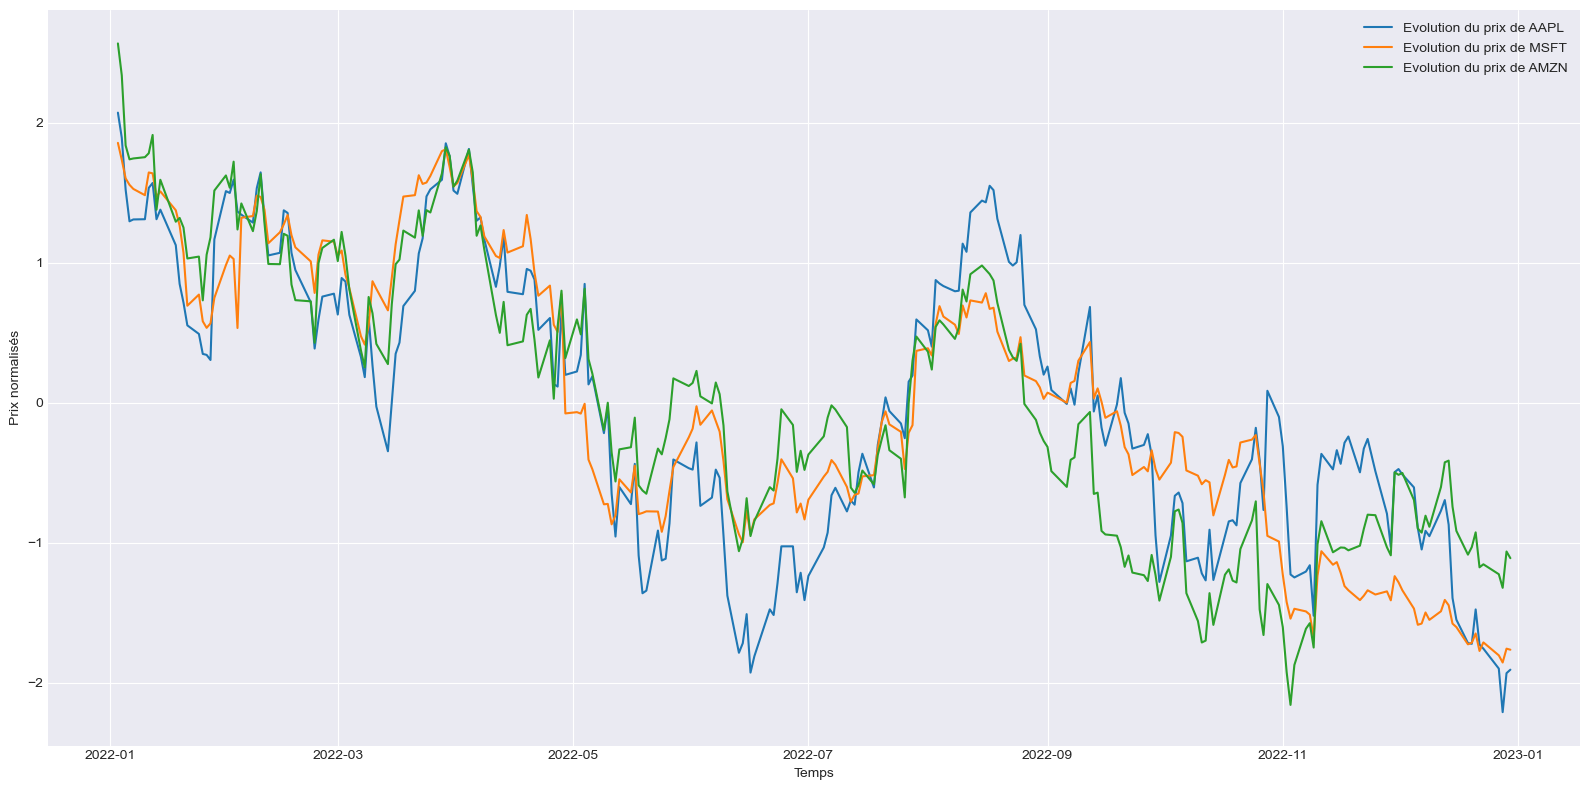

In [16]:
engine.plot_serie_prix()

## Comparer deux définitions fondamentales du rendement.
## Analyse:
#### Rendement simple : intuitif mais non additif
#### Rendement logarithmique : cohérent temporellement
#### Mesure de l’erreur moyenne et de variance entre les deux

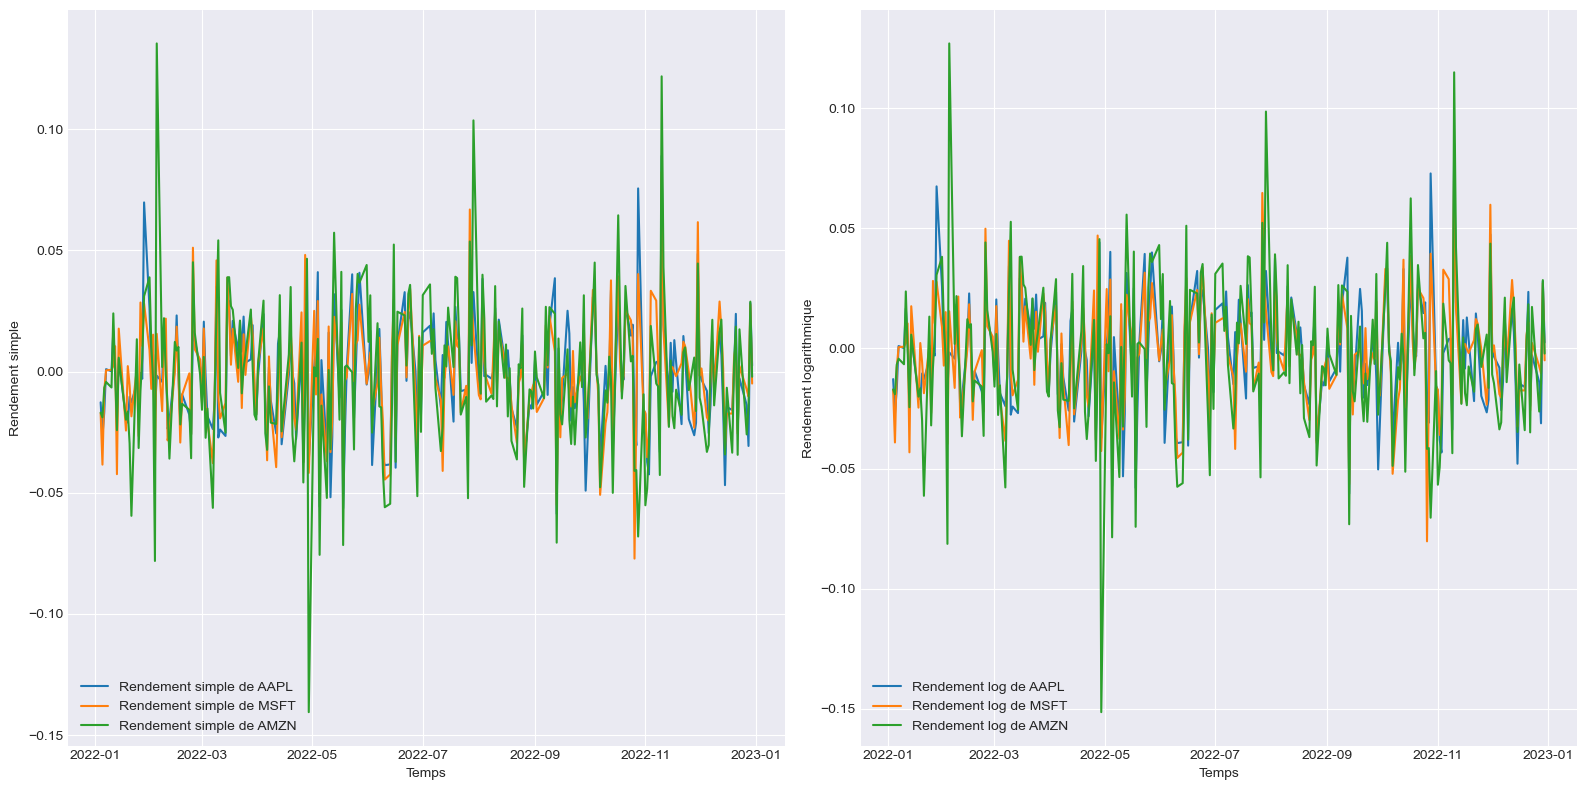

--------------------------------------------------
Différence moyenne (rendement simple - log): Ticker
AAPL    0.025161
AMZN    0.050030
MSFT    0.024817
dtype: float64
Variance de la différence: Ticker
AAPL    0.000018
AMZN    0.000123
MSFT    0.000017
dtype: float64
--------------------------------------------------


In [17]:
engine.plot_serie_rend()

## Estimation du couple rendement / risque par actif.
## Analyse:
#### Rendement moyen historique
#### Volatilité comme proxy du risque
#### Base de toute allocation moderne

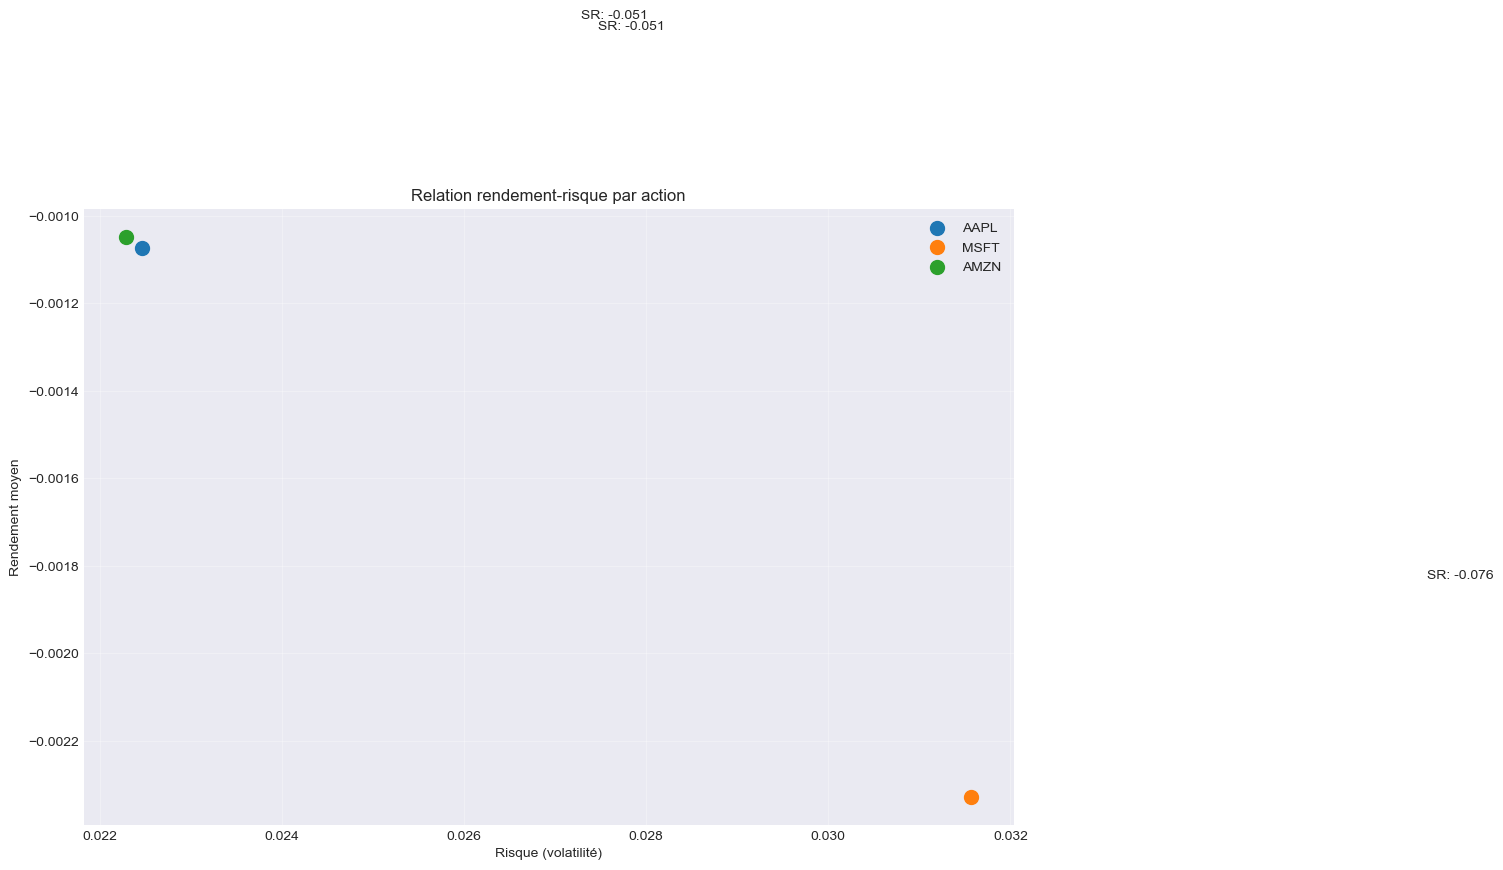

In [18]:
engine.plot_ren_risk(r_f=0.02)

## Mesurer la dépendance linéaire entre actifs.
## Analyse:
#### Cœur du modèle moyenne-variance
#### Détection de risques systémiques
#### Base du calcul de la variance portefeuille

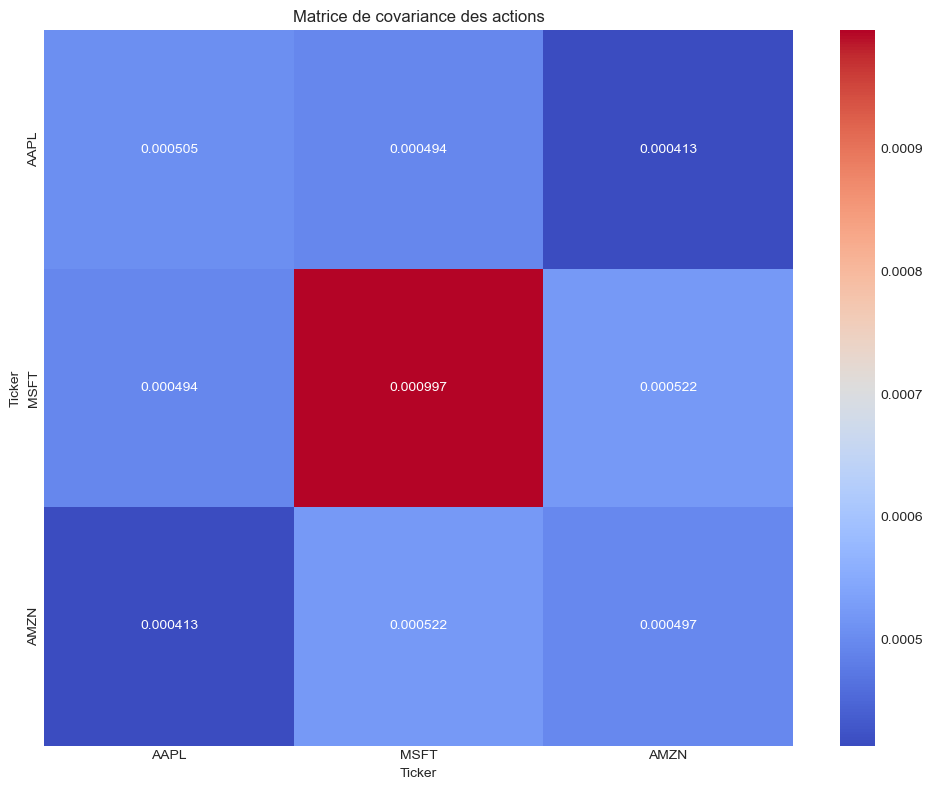

In [19]:
engine.heatmap_cov()

## Construction du portefeuille :
#### variance minimale
#### rendement cible optionnel
## analyse:
#### Contraintes réalistes (poids ≥ 0, somme = 1)
#### Optimisation quadratique
#### Méthode SLSQP

In [20]:
w_min_var = engine.opti_moy_vari()
w_target = engine.opti_moy_vari(E_target=0.0005)

## Visualisation de l’ensemble des portefeuilles réalisables.
## Analyse:
#### Simulation Monte Carlo
#### Identification des portefeuilles dominants
#### Comparaison avec actifs individuels

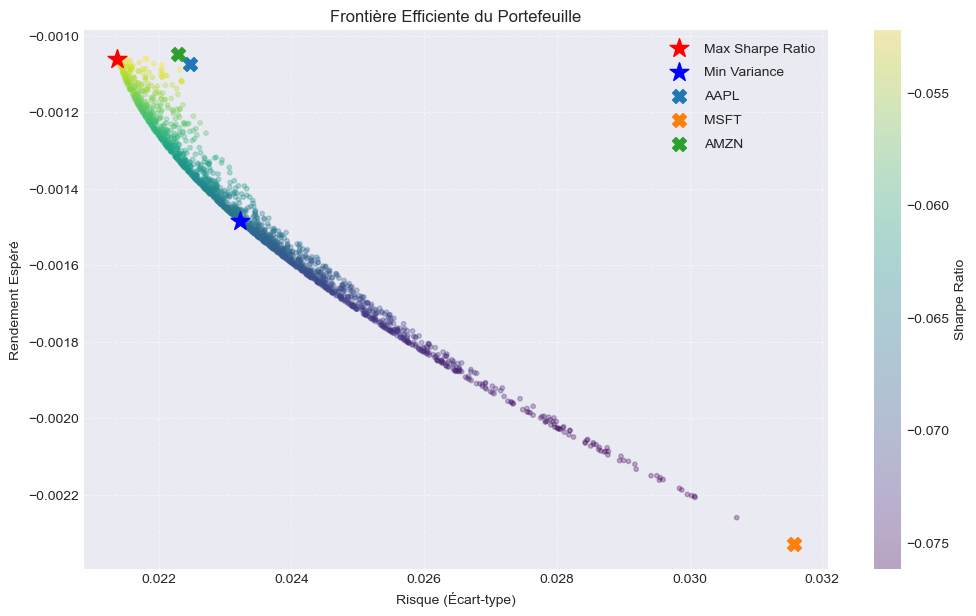

In [21]:
engine.plot_efficient_frontier(r_f=0.02)

## Quantification des pertes extrêmes potentielles.
## Analyse:
#### VaR paramétrique : hypothèse de normalité
#### VaR historique : empirique
#### CVaR : cohérente et plus conservatrice

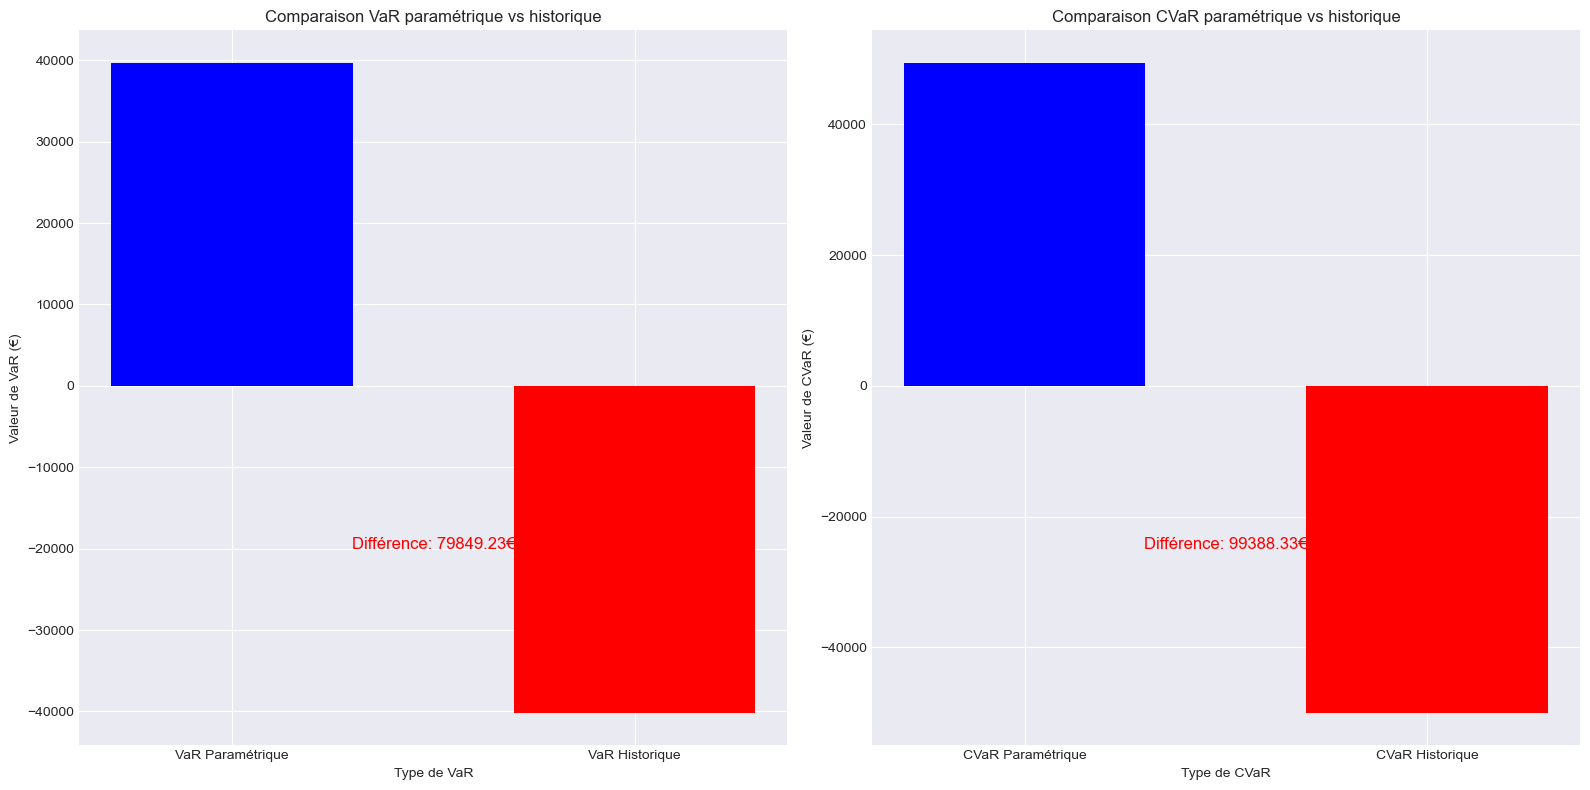

In [22]:
engine.compa_hist_para(conf=0.95)

## Évaluation du portefeuille sous crises réelles
## Analyse:
#### 2008, COVID, bulle internet
#### Rupture des hypothèses stationnaires
#### Vision prudente du risque

[*********************100%***********************]  3 of 3 completed


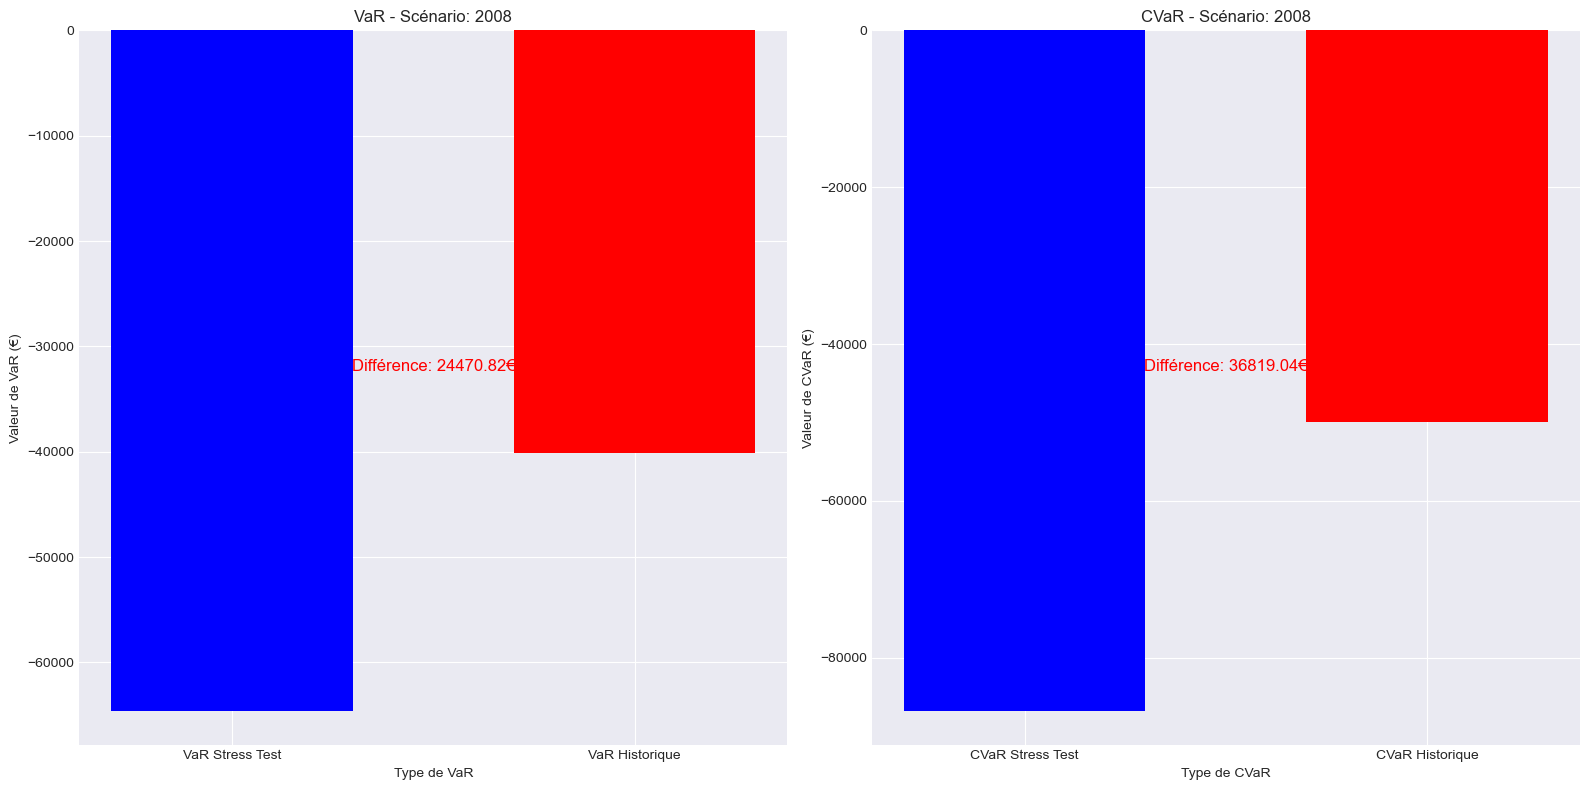

In [23]:
engine.scenario_test_stress(scenario="2008", conf=0.95)

## Cette section compare trois stratégies d’allocation sur le même univers d’actifs et la même période :
#### Portefeuille équipondéré (benchmark naïf)
#### Portefeuille à variance minimale
#### Portefeuille maximisant le ratio de Sharpe
### L’objectif est d’évaluer l’impact réel de l’optimisation sur le risque et la performance
## Analyse:
#### L’équipondération sert de référence simple, souvent utilisée en pratique
#### L’optimisation moyenne-variance vise la réduction du risque total
#### L’optimisation Sharpe cherche le meilleur compromis rendement / risque
#### Les comparaisons sont faites via :
##### VaR (95 %)
##### CVaR (95 %)
##### Stress test historique (2008)
#### Tout est fait à hypothèses identiques, ce qui rend la comparaison valide

In [25]:
actions=["AAPL", "MSFT", "AMZN"]
weight_minvar = engine.opti_moy_vari()
weight_sharpe = engine.opti_max_sharp(r_f=0.002)

portfo_minvar = portfolioengine(
    actions,
    start="2022-01-01",
    end="2022-12-31",
    V=1_000_000,
    T=252,
    weight=weight_minvar
)

portfo_sharpe = portfolioengine(
    actions,
    start="2022-01-01",
    end="2022-12-31",
    V=1_000_000,
    T=252,
    weight=weight_sharpe
)

print("Poids équipondérés:", np.ones(len(actions)) / len(actions))
print("Poids variance minimale:", weight_minvar)
print("Poids Sharpe maximum:", weight_sharpe)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed

Poids équipondérés: [0.33333333 0.33333333 0.33333333]
Poids variance minimale: [0.33333333 0.33333333 0.33333333]
Poids Sharpe maximum: [4.86047530e-01 1.66533454e-16 5.13952470e-01]


## Analyse:
#### La VaR mesure la perte maximale attendue à un niveau de confiance donné, sous hypothèse de normalité.
### Elle est sensible aux hypothèses, mais reste un standard industriel.

In [26]:
var_equi = engine.var_parametr(conf=0.95)
var_minvar = portfo_minvar.var_parametr(conf=0.95)
var_sharpe = portfo_sharpe.var_parametr(conf=0.95)

print(f"VaR (95%) - Equipondéré: {var_equi:.2f} €")
print(f"VaR (95%) - Variance minimale: {var_minvar:.2f} €")
print(f"VaR (95%) - Sharpe maximal: {var_sharpe:.2f} €")

VaR (95%) - Equipondéré: 39688.37 €
VaR (95%) - Variance minimale: 39688.36 €
VaR (95%) - Sharpe maximal: 36221.13 €


## Analyse:
#### La CVaR capture la perte moyenne au-delà de la VaR, donc le vrai risque de crise.
### C’est beaucoup plus pertinent pour un risk manager

In [27]:
cvar_equi = engine.cvar_histori(conf=0.95)
cvar_minvar = portfo_minvar.cvar_histori(conf=0.95)
cvar_sharpe = portfo_sharpe.cvar_histori(conf=0.95)

print(f"CVaR (95%) - Equipondéré: {cvar_equi:.2f} €")
print(f"CVaR (95%) - Variance minimale: {cvar_minvar:.2f} €")
print(f"CVaR (95%) - Sharpe maximal: {cvar_sharpe:.2f} €")

CVaR (95%) - Equipondéré: -49994.43 €
CVaR (95%) - Variance minimale: -49994.43 €
CVaR (95%) - Sharpe maximal: -44047.91 €


## Analyse
#### On sort du cadre statistique et on injecte une vraie crise.
### C’est là que beaucoup de modèles s’effondrent

In [28]:
scenario = "2008"

_, var_stress, cvar_stress = engine.stress_test(scenario, conf=0.95)
print(f"VaR Stress Test {scenario}: {var_stress:.2f} €")
print(f"CVaR Stress Test {scenario}: {cvar_stress:.2f} €")

_, var_stress, cvar_stress = portfo_sharpe.stress_test(scenario, conf=0.95)
print(f"VaR Stress Test {scenario}: {var_stress:.2f} €")
print(f"CVaR Stress Test {scenario}: {cvar_stress:.2f} €")

_, var_stress, cvar_stress = portfo_minvar.stress_test(scenario, conf=0.95)
print(f"VaR Stress Test {scenario}: {var_stress:.2f} €")
print(f"CVaR Stress Test {scenario}: {cvar_stress:.2f} €")


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


VaR Stress Test 2008: -64631.68 €
CVaR Stress Test 2008: -86813.47 €
VaR Stress Test 2008: -60028.64 €
CVaR Stress Test 2008: -78248.79 €


[*********************100%***********************]  3 of 3 completed

VaR Stress Test 2008: -64631.68 €
CVaR Stress Test 2008: -86813.47 €


## Remarques critiques:
#### Sensibilité extrême aux estimations de moyenne/covariance
#### Hypothèse de normalité non testée
#### Pas de contraintes réalistes (turnover, coûts)

## Conclusion:
### Cette comparaison montre que l’optimisation n’est pas une fin en soi :
#### – la variance minimale réduit efficacement le risque extrême
#### – le Sharpe maximum améliore le rendement ajusté au risque mais peut accroître l’exposition en crise
### Le choix d’allocation dépend donc du profil de risque et du contexte de marché, et non d’un critère unique.